# I G N i t E    T U T o R i A L

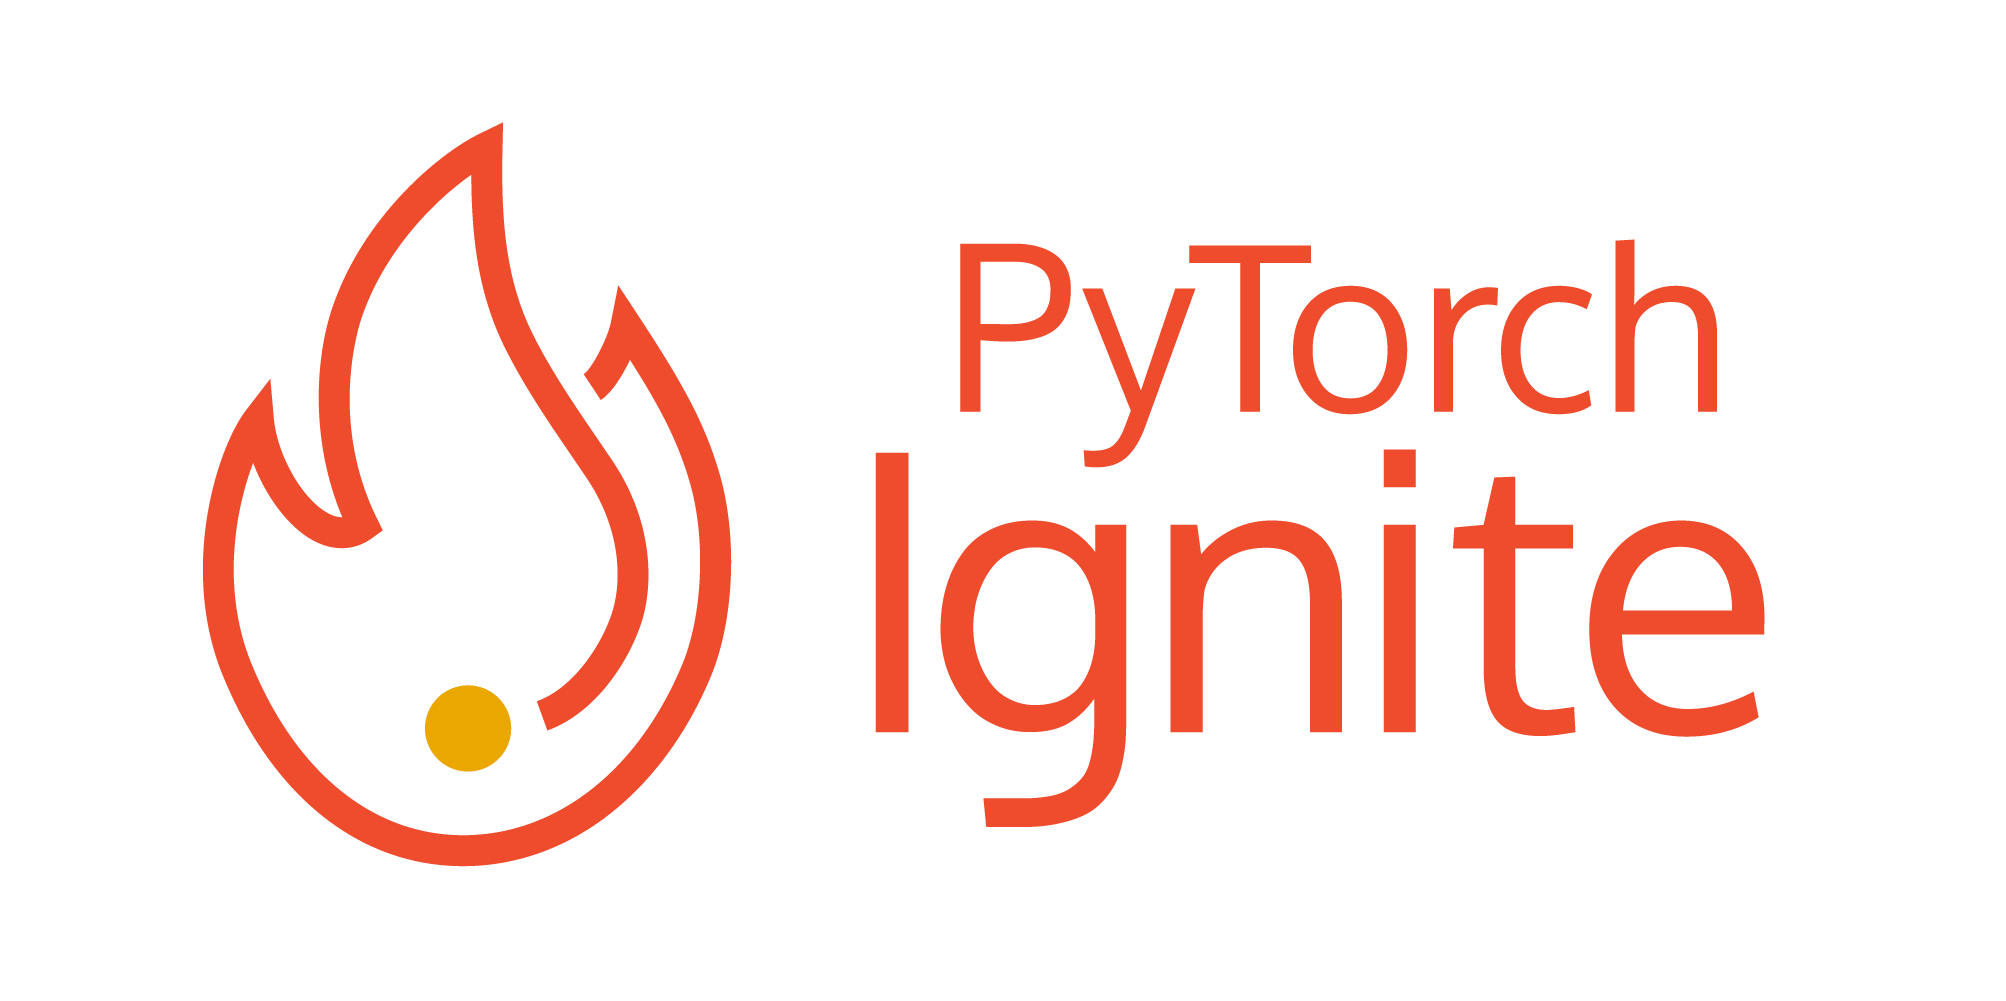!

### DATASET

In [ ]:
import torch
import torch.nn as nn
from skimage import io, transform

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,image_path,features,targets,augmentations=None):
        self.image_path = image_path
        self.features = features
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self,item):
        image = io.imread(self.image_path[item])
        features = self.features[item,:]
        targets = self.targets[item]
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "features": torch.tensor(features, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.float),
        }

In [ ]:
! pip install timm
import timm

## Writing train and eval for one epoch known as engine.py

In [ ]:
def train(model,train_loader,device,optimizer):
    model.train()
    running_train_loss = 0.0
    for data in train_loader:
        inputs = data['image']
        features = data['features']
        targets = data['targets']

        inputs = inputs.to(device, dtype=torch.float)
        features = features.to(device,dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs,features)
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_train_loss +=loss.item()
        
    train_loss_value = running_train_loss/len(train_loader)
    print(f'train BCE loss is {train_loss_value}')
    
def eval(model,valid_loader,device,optimizer):
    model.eval()
    final_targets = []
    final_outputs = []
    running_val_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
            inputs = data['image']
            features = data['features']
            targets = data['targets']
            inputs = inputs.to(device, dtype=torch.float)
            features = features.to(device,dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            output = model(inputs,features)
            running_val_loss += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1))
            targets = (targets.detach().cpu().numpy()*100).tolist()
            output = (torch.sigmoid(output).detach().cpu().numpy()*100).tolist()
            final_outputs.extend(output)
            final_targets.extend(targets)
        val_loss = running_val_loss/len(valid_loader)    
        print(f'valid BCE loss is {val_loss}')
    return final_outputs,final_targets

## same  with ignite engine

In [ ]:

from ignite.engine import Engine
from ignite.metrics import RootMeanSquaredError
from ignite.engine import Events

def train_step(engine, batch):
    model.train()
    inputs, features, targets = batch['image'],batch['features'],batch['targets']
    inputs = inputs.to(device)
    features = features.to('cuda')
    targets = targets.to('cuda')
    optimizer.zero_grad()
    outputs = model(inputs, features)
    loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_step)

def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        inputs, features, targets = batch['image'],batch['features'],batch['targets']
        inputs = inputs.to('cuda')
        features = features.to('cuda')
        targets = targets.to('cuda')*100
        
        outputs = model(inputs, features)
        outputs = torch.sigmoid(outputs)*100
        
        return outputs, targets
evaluator = Engine(validation_step)




### MODEL CREATED

In [ ]:
import torch
import torch.nn as nn

model_name = 'swin_large_patch4_window12_384_in22k'

out_dim    = 1

class get_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.model.head = nn.Sequential(nn.Linear(self.model.head.in_features,768),
                                              nn.Linear(768,256))
        self.last = nn.Linear(256 + 12, 128)
        self.depth1 = nn.Linear(128,64)
        self.depth2 = nn.Linear(64,1)
    def forward(self, image, features):
        x = self.model(image)
        x = self.last(torch.cat([x, features], dim=1))
        x = self.depth1(x)
        x = self.depth2(x)
        return x

In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection
df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
df["kfold"] = -1

df = df.sample(frac=1).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df,y=df.Pawpularity.values)):
    print(len(train_idx), len(val_idx))
    df.loc[val_idx, 'kfold'] = fold

In [ ]:
import os
from sklearn import metrics
import albumentations
device = 'cuda'

data_path = '../input/petfinder-pawpularity-score'
train_aug = albumentations.Compose(                  ##  AUGMENTATIONs TAKEN FROM ABHISHEK THAKUR's tez Pawpular training
    [
        albumentations.Resize(384,384, p=1),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)

valid_aug = albumentations.Compose(
    [
        albumentations.Resize(384, 384, p=1),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)
feats = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]

# iGNiTE PART

In [ ]:
import ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import RootMeanSquaredError, Loss
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.engines.common import save_best_model_by_val_score
from ignite.handlers import  EarlyStopping, ModelCheckpoint 
from ignite.utils import setup_logger
import tqdm
epochs=20
lr=5e-5 


for fold in range(5):
    print(f'You are in Fold {fold}')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    df_train = df_train.drop(columns = 'kfold')
    df_valid = df_valid.drop(columns = 'kfold')

    train_images = df_train.Id.values.tolist()
    train_images = [os.path.join(data_path,'train',i + '.jpg') for i in train_images]
    valid_images = df_valid.Id.values.tolist()
    valid_images = [os.path.join(data_path,'train',i + '.jpg') for i in valid_images]

    train_targets = df_train.Pawpularity.values/100
    valid_targets = df_valid.Pawpularity.values/100

    train_dataset = CustomDataset(image_path = train_images,features=df_train[feats].values,targets = train_targets,augmentations=train_aug)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,pin_memory=True) 
    valid_dataset = CustomDataset(image_path = valid_images,features=df_valid[feats].values,targets =valid_targets,augmentations=valid_aug)
    val_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=8,shuffle=False,pin_memory=True) 
    
    device = 'cuda'
    model = get_model()
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    criterion = nn.BCEWithLogitsLoss()
    
    trainer = Engine(train_step)

    evaluator = Engine(validation_step)

    RootMeanSquaredError().attach(evaluator, "rmse")
    validate_every = 1

    metrics:{
        'rmse':RootMeanSquaredError()
    }
    @trainer.on(Events.EPOCH_COMPLETED(every=validate_every))
    def run_validation():
        evaluator.run(val_loader)
    
    @trainer.on(Events.EPOCH_COMPLETED(every=validate_every))
    def log_validation():
        metrics = evaluator.state.metrics
        print(f"Epoch: {trainer.state.epoch},  RMSE: {metrics['rmse']}")
        
#     add handlers ...  for 
    def score_function(engine):
        val_rmse = engine.state.metrics['rmse']
        return -val_rmse
    
    handler = EarlyStopping(patience=4, score_function=score_function, trainer=trainer)
    evaluator.add_event_handler(Events.COMPLETED, handler)
    
    

    checkpointer = save_best_model_by_val_score(output_path = './' , evaluator = evaluator, 
                                                             model = model, metric_name = str(fold)+''+str(trainer.state.epoch), n_saved=2, 
                                                             trainer=None, tag='rmse')
    
    ProgressBar().attach(trainer)
    
    trainer.run(train_loader, epochs)
    